# Studying micrograd + Building it from scratch

# 7/5/2023

**Changes:**

1. Added power function.
2. Added new example that uses power function.

In [1]:
from math import exp
import numpy as np

In [2]:
class Value:
    def __init__(self, data, _children=(), _op=""):
        self.data = data
        self.grad = 0.0
        # internal variables
        self._backward = lambda: None
        self._prev = set(_children) # stores previous objects
        self._op = _op # stores the operation
    
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})" # stores the value and it's grad
    
    def __add__(self, other): # addition
        out = Value(self.data + other.data, (self, other), '+')
        other = other if isinstance(other, Value) else Value(other)
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other): # multiplication
        out = Value(self.data * other.data, (self, other), '*')
        other = other if isinstance(other, Value) else Value(other)
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "must be a number not a Value"
        out = Value(self.data ** other, (self,), '**')
        def _backward():
            self.grad += (other * self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    
    def backward(self): # performs backpropagation to calculate gradients for all the nodes
    
        # topological order
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        # applies chain rule one var at a time
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [3]:
# an example

x = Value(2.0)
y = Value(3.0)

x_2 = x ** 2
xy = x * y

# func
z = xy + x_2

# grads
z.backward()

# results
print(f"x: {x}")
print(f"y: {y}")
print(f"X_2: {x_2}")
print(f"xy: {xy}")
print(f"z: {z}")

x: Value(data=2.0, grad=7.0)
y: Value(data=3.0, grad=2.0)
X_2: Value(data=4.0, grad=1.0)
xy: Value(data=6.0, grad=1.0)
z: Value(data=10.0, grad=1.0)


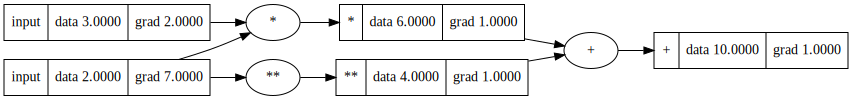

In [4]:
from graphviz import Digraph

def trace(root): # builds a set of our nodes
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root): # draws the SVG graph of our example
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        op_label = n._op or "input"
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (op_label, n.data, n.grad), shape='record')

        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

draw_dot(z)